In [1]:
import os 
import numpy as np 

from NirsLabProject.config.consts import *
from NirsLabProject.utils import pipeline_utils as putils
from NirsLabProject.config.subject import Subject
from NirsLabProject.utils import plotting




In [7]:
subjects_stats = {
    AMPLITUDE_INDEX: {},
    DURATION_INDEX: {},
    GROUP_EVENT_DURATION_INDEX: {},
    GROUP_EVENT_SIZE_INDEX: {},
    GROUP_EVENT_SPATIAL_SPREAD_INDEX: {},
    GROUP_EVENT_DEEPEST_INDEX: {},
    GROUP_EVENT_SHALLOWEST_INDEX: {},
}

feature_id_to_title = {
    AMPLITUDE_INDEX: 'Spike Amplitude Average',
    DURATION_INDEX: 'Spike Width Average',
    GROUP_EVENT_DURATION_INDEX: 'Spike Group Event Duration Average',
    GROUP_EVENT_SIZE_INDEX: 'Spike Group Event Size Average',
    GROUP_EVENT_SPATIAL_SPREAD_INDEX: 'Spike Group Event Spatial Spread Average',
    GROUP_EVENT_DEEPEST_INDEX: 'Spike Group Event Deepest Electrode Avrage',
    GROUP_EVENT_SHALLOWEST_INDEX: 'Spike Group Event Shallowest Electrode Avrage',
}

stimuli_subjects = putils.get_subjects(
    filters=[
        lambda subj: subj.stimuli_project,
        lambda subj: os.path.exists(subj.paths.subject_flat_features_path),
    ],
    sort_key=lambda subj: subj.p_number,
)
subjects = {
    s: s for s in stimuli_subjects
}

nrem_subjects_blocks = {}
subjects_blocks = {}
for subj, stimuli_subjects in subjects.items():
    if subj == stimuli_subjects:
        if os.path.exists(subj.paths.subject_sleep_scoring_path):
            nrem_data_of_blocks = putils.get_stimuli_subject_blocks(subj, only_nrem=True)
            data_of_blocks = putils.get_stimuli_subject_blocks(subj, only_nrem=False)
        else:
            print(f'stimuli {subj.p_number}')
            continue
    else:
        print(f'control {subj.p_number} with {stimuli_subjects.p_number}')
        if os.path.exists(subj.paths.subject_hypnogram_path):
            nrem_data_of_blocks = get_control_subject_blocks(subj, stimuli_subjects, only_nrem=True)
            data_of_blocks = get_control_subject_blocks(subj, stimuli_subjects, only_nrem=False)
        else:
            continue
    nrem_subjects_blocks[subj] = nrem_data_of_blocks
    subjects_blocks[subj] = data_of_blocks

block_names = ['before window', 'stim block', 'pause block', 'after window']

 ## Temporal vs Frontal

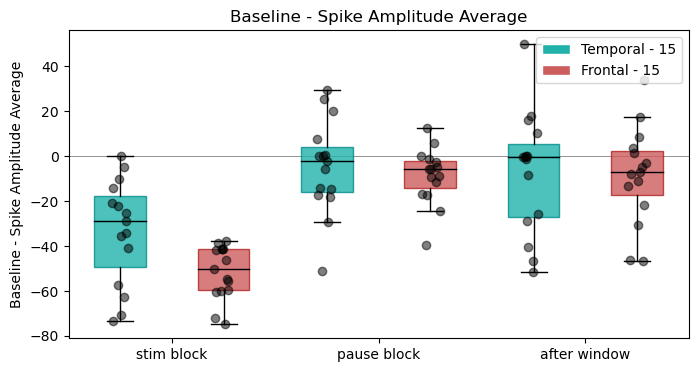

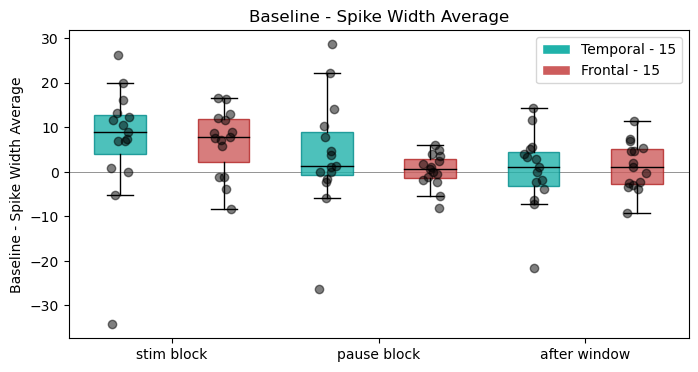

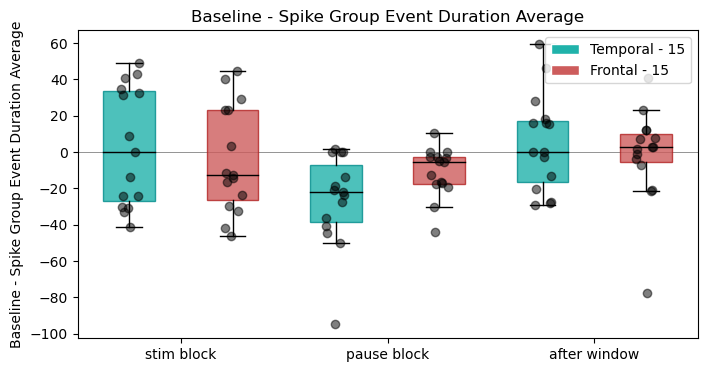

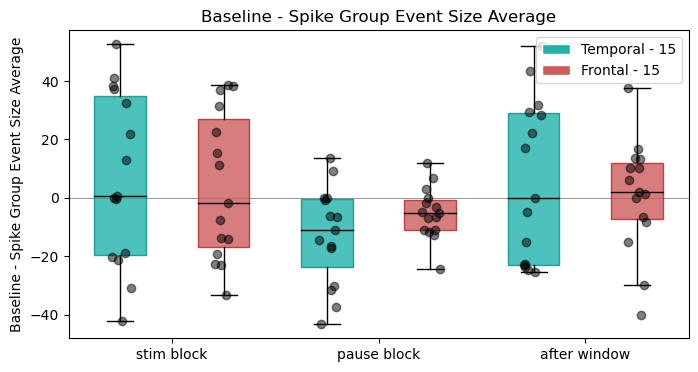

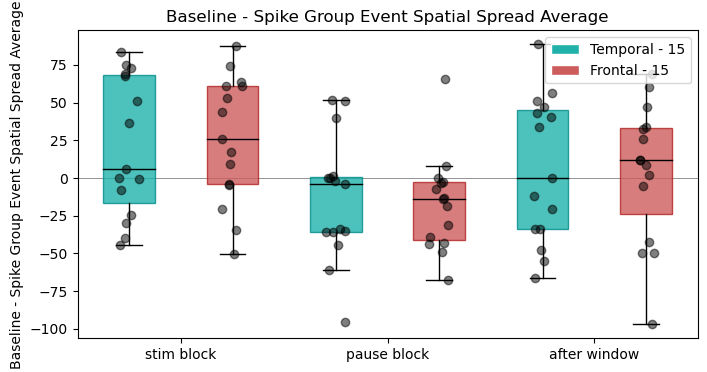

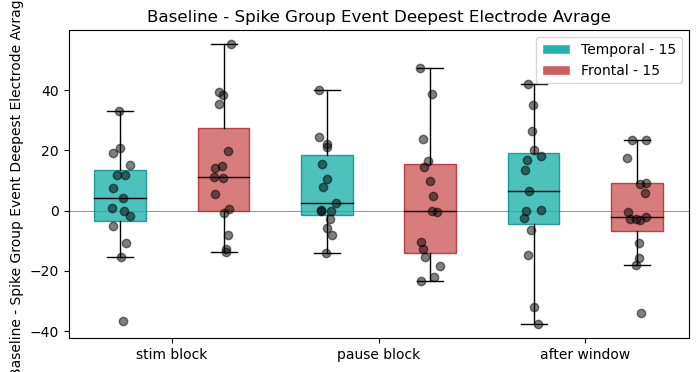

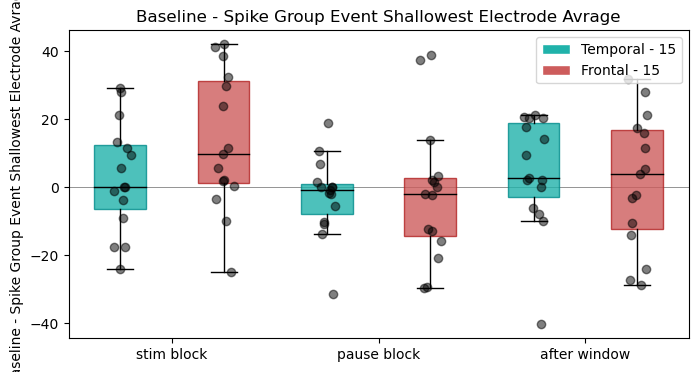

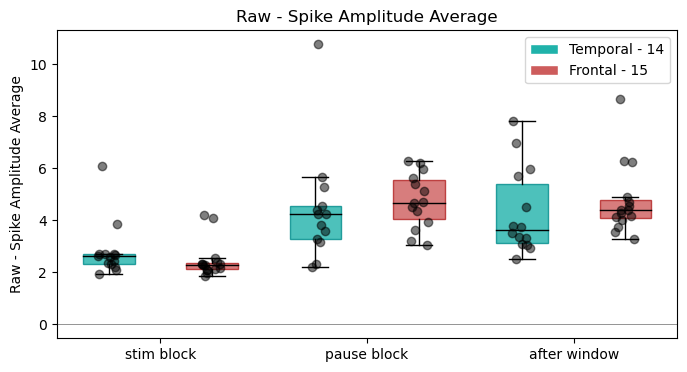

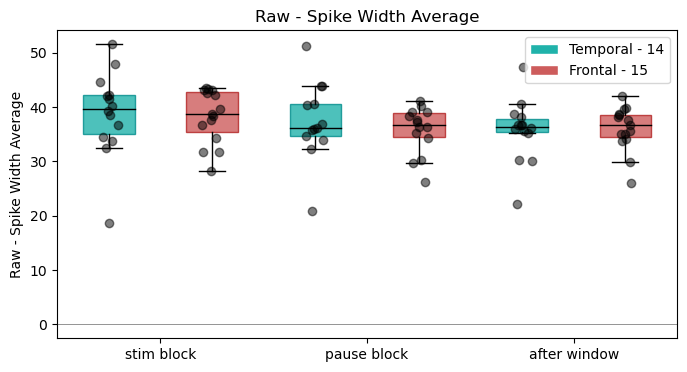

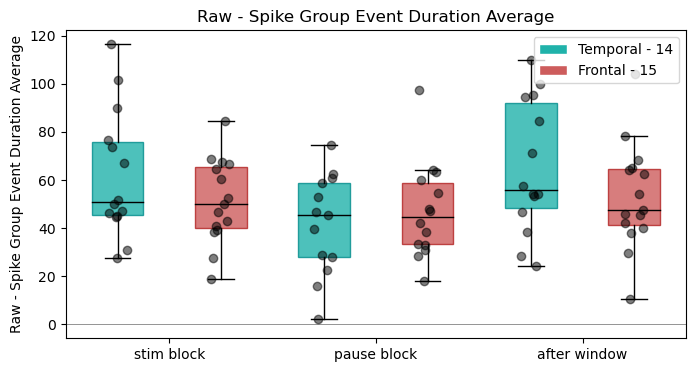

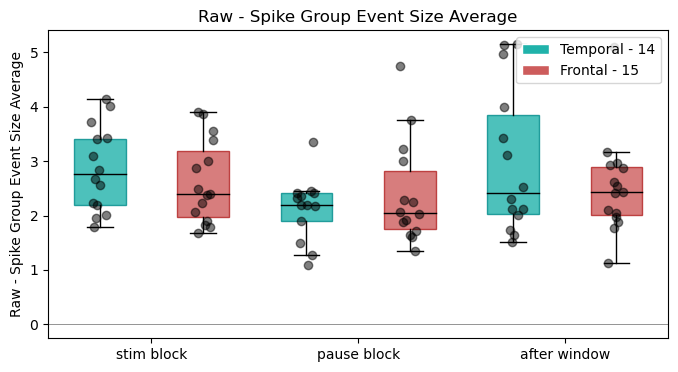

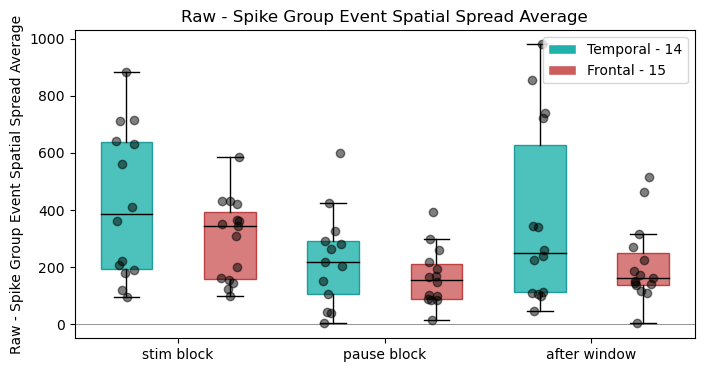

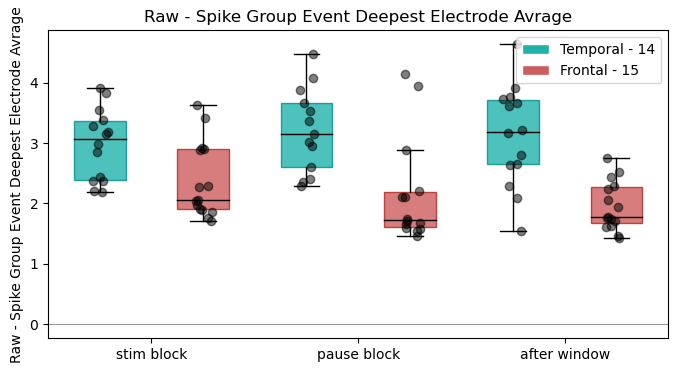

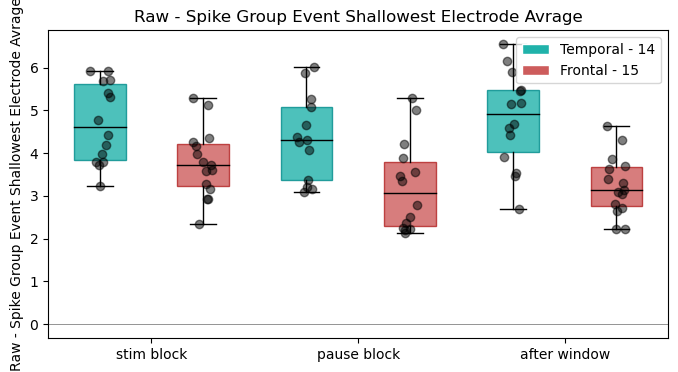

In [10]:
def temporal_frontal_seperator(block_features, subj, feature_index):
        groups = ['temporal', 'frontal']
        frontal_chans = ['ROF', 'LOF', 'RAC', 'LAC', 'LAF', 'RAF', 'RFA', 'RIF-dAC', 'LOPR']
        temporal_chans = ['RA', 'LA', 'RAH', 'LAH', 'RMH', 'LMH', 'REC', 'LEC', 'RPHG', 'LPHG']
        index_to_channel_name = np.load(subj.paths.subject_channel_name_to_index_path, allow_pickle=True).item()
        channel_name_to_index = {channel_name: index for index, channel_name in index_to_channel_name.items()}
        frontal_chans = [channel_name_to_index[f'{chan}{i}'] for i in range(1,8) for chan in frontal_chans if f'{chan}{i}' in channel_name_to_index]
        temporal_chans = [channel_name_to_index[f'{chan}{i}'] for i in range(1,8) for chan in temporal_chans if f'{chan}{i}' in channel_name_to_index]

        
        frontal = {
            block_name: np.mean(features[np.where(np.isin(features[:, CHANNEL_INDEX], frontal_chans))][:, feature_index])
            for block_name, features in block_features.items()
        }
        
        temporal = {
            block_name: np.mean(features[np.where(np.isin(features[:, CHANNEL_INDEX], temporal_chans))][:, feature_index])
            for block_name, features in block_features.items()
        } 
        return groups, {
            groups[0]: frontal,
            groups[1]: temporal,
        }
    
for compare_to_base_line in [True, False]:
    results = {}
    groups = ['temporal', 'frontal']
    for feature_index in subjects_stats.keys():
        is_group_feature = GROUP_INDEX <= feature_index <= GROUP_EVENT_SPATIAL_SPREAD_INDEX
        prefix = 'group ' if is_group_feature else ''
        if compare_to_base_line:
            _block_names = block_names[1:]
        else:
            _block_names = block_names[1:]
        results[feature_index] = {
            block_name: {group: [] for group in groups} for block_name in _block_names
        }
        for subject in subjects.keys():
            groups, groups_menas = temporal_frontal_seperator(nrem_subjects_blocks[subject], subject, feature_index)        
            for group in groups:
                group_data = groups_menas[group]
                for block_name in _block_names:
    #                 print(feature_index)
    #                 print(group_data[prefix+'before window'], group_data[prefix+block_name])
                    if compare_to_base_line:
                        results[feature_index][block_name][group].append(
                            putils.baseline_diff(group_data[prefix+'before window'], group_data[prefix+block_name])
                        )
                    else:
                        results[feature_index][block_name][group].append(
                            group_data[prefix+block_name]
                        )

    subject = Subject(STIMULI_PROJECT_INTERSUBJECTS_SUBJECT_NAME, True)
    path = os.path.join(subject.paths.subject_stimuli_effects_plots_dir_path, 'frontal-temporal')
    if not os.path.exists(path):
        os.makedirs(path)
        
    for feature_index, stats in results.items():
        plotting.create_box_plot_for_stimuli(
            figure_path=path,
            data_channels=results[feature_index],
            feature_name=('Baseline - ' if compare_to_base_line else 'Raw - ') + feature_id_to_title[feature_index],
        )


## NREN vs REM/WAKE

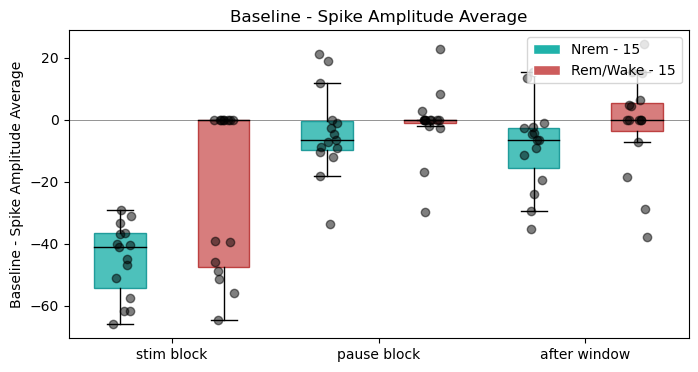

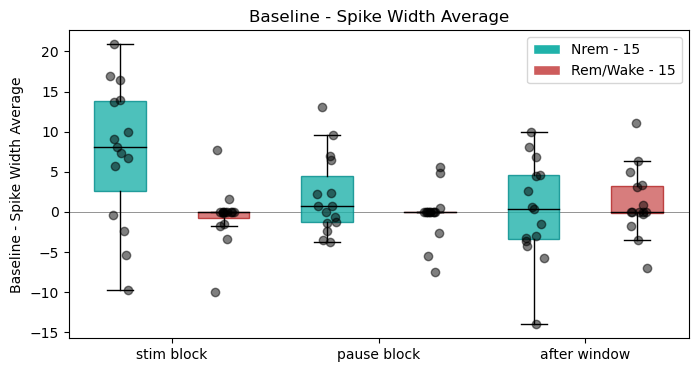

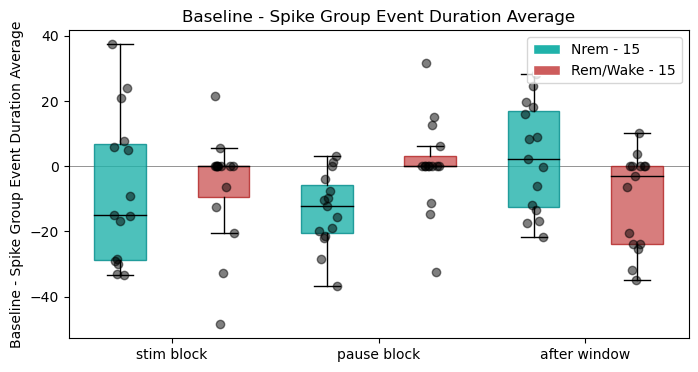

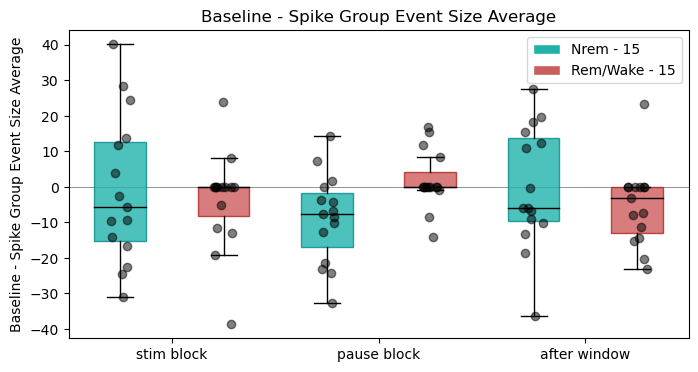

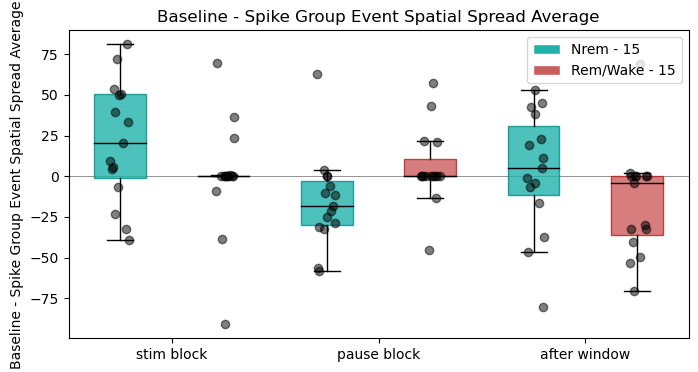

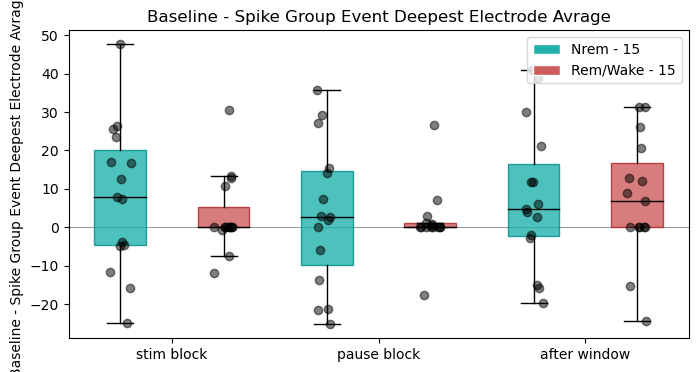

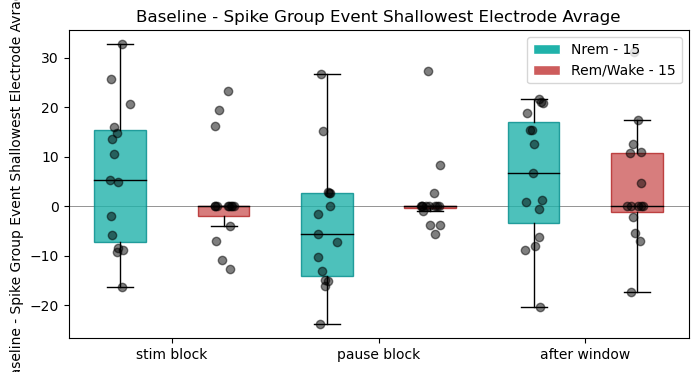

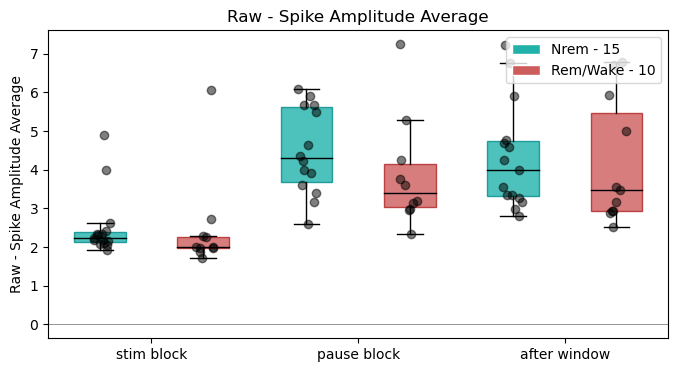

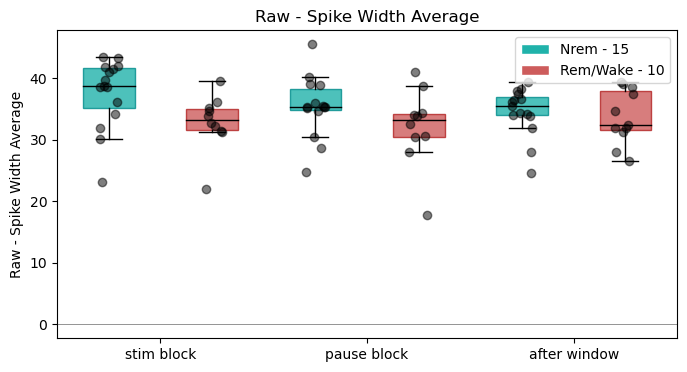

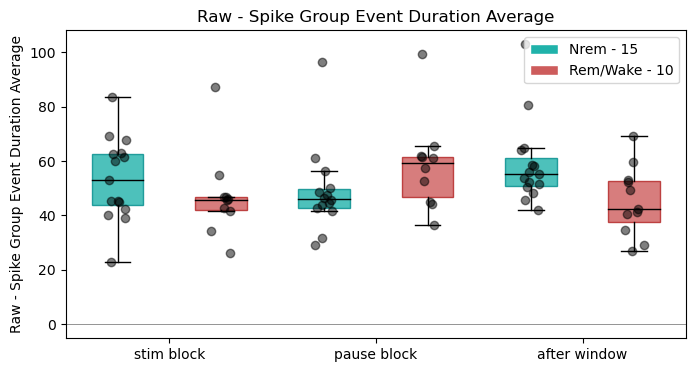

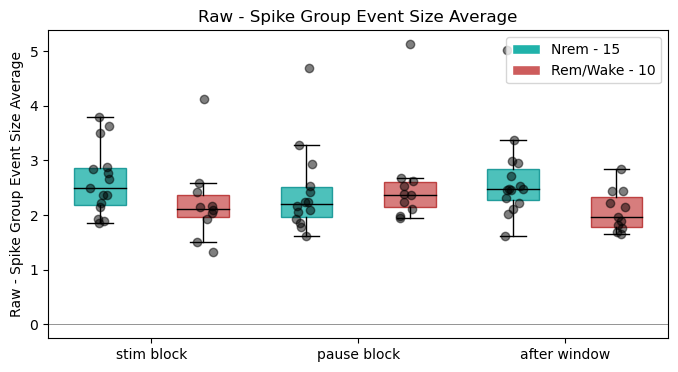

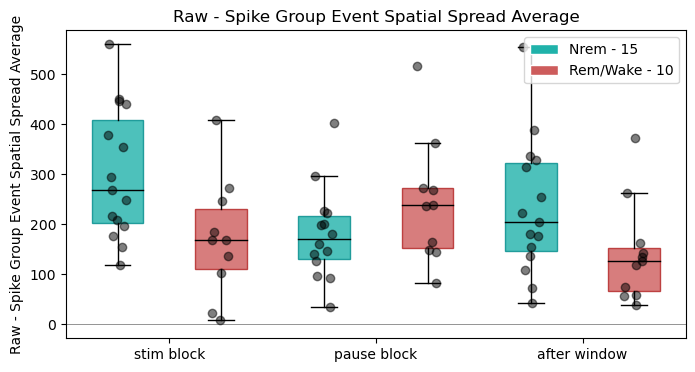

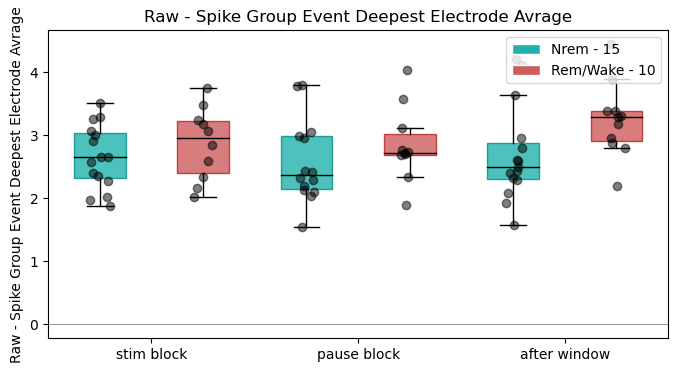

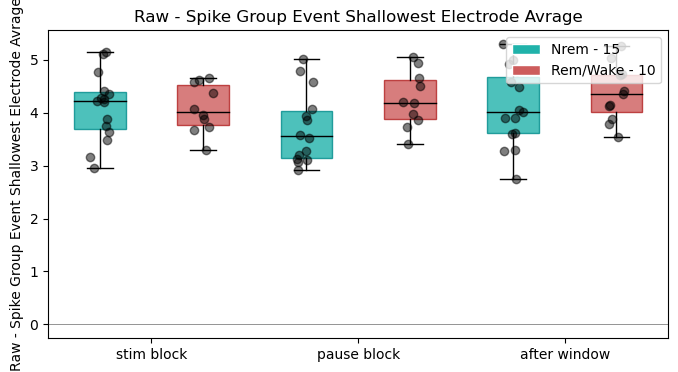

In [25]:
def nrem_seperator(block_features, subj, feature_index):
        groups = ['NREM', 'REM/Wake']
        nrem = {
            block_name: np.mean(features[features[:, HYPNOGRAM_FLAG_INDEX] == HYPNOGRAM_FLAG_NREM][:, feature_index])
            for block_name, features in block_features.items()
        }
        
        rest = {
            block_name: np.mean(features[features[:, HYPNOGRAM_FLAG_INDEX] != HYPNOGRAM_FLAG_NREM][:, feature_index])
            for block_name, features in block_features.items()
        } 
        
        return groups, {
            groups[0]: nrem,
            groups[1]: rest,
        }
    
for compare_to_base_line in [True, False]:
    results = {}
    groups = ['NREM', 'REM/Wake']
    for feature_index in subjects_stats.keys():
        is_group_feature = GROUP_INDEX <= feature_index <= GROUP_EVENT_SPATIAL_SPREAD_INDEX
        prefix = 'group ' if is_group_feature else ''
        if compare_to_base_line:
            _block_names = block_names[1:]
        else:
            _block_names = block_names[1:]
        results[feature_index] = {
            block_name: {group: [] for group in groups} for block_name in _block_names
        }
        for subject in subjects.keys():
            groups, groups_menas = nrem_seperator(subjects_blocks[subject], subject, feature_index)        
            for group in groups:
                group_data = groups_menas[group]
                for block_name in _block_names:
    #                 print(feature_index)
    #                 print(group_data[prefix+'before window'], group_data[prefix+block_name])
                    if compare_to_base_line:
                        results[feature_index][block_name][group].append(
                            putils.baseline_diff(group_data[prefix+'before window'], group_data[prefix+block_name])
                        )
                    else:
                        results[feature_index][block_name][group].append(
                            group_data[prefix+block_name]
                        )

    subject = Subject(STIMULI_PROJECT_INTERSUBJECTS_SUBJECT_NAME, True)
    path = os.path.join(subject.paths.subject_stimuli_effects_plots_dir_path, 'NREM-REMorWake')
    if not os.path.exists(path):
        os.makedirs(path)
        
    for feature_index, stats in results.items():
        plotting.create_box_plot_for_stimuli(
            figure_path=path,
            data_channels=results[feature_index],
            feature_name=('Baseline - ' if compare_to_base_line else 'Raw - ') + feature_id_to_title[feature_index],
        )
